In [93]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 

db=mysql.connector.connect(
    host='localhost',
    user='root',
    password='S@gar7870',
    database='ecommerce'
)



In [ ]:
import os
import pandas as pd
import mysql.connector

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items'),
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='S@gar7870',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/sagar/Desktop/data analytics all project/python+sql/archive'

def get_sql_type(dtype):
    """Map pandas dtypes to MySQL data types."""
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# Batch size for processing large datasets
batch_size = 1000

for csv_file, table_name in csv_files:
    try:
        file_path = os.path.join(folder_path, csv_file)
        
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Replace NaN with None to handle SQL NULL
        df = df.where(pd.notnull(df), None)
        
        # Clean column names
        df.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        # Debugging: Print first few rows and column names
        print(f"Processing {csv_file}")
        print(f"Columns: {df.columns.tolist()}")
        print(f"Sample data:\n{df.head()}\n")
        
        # Generate the CREATE TABLE statement with appropriate data types
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        cursor.execute(create_table_query)

        # Prepare data for batch insertion
        values = [
            tuple(None if pd.isna(x) else x for x in row)
            for row in df.to_numpy()
        ]
        placeholders = ', '.join(['%s'] * len(df.columns))
        insert_query = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({placeholders})"

        # Insert in batches
        for i in range(0, len(values), batch_size):
            batch = values[i:i + batch_size]
            cursor.executemany(insert_query, batch)
            conn.commit()

        print(f"Data imported successfully for table: {table_name}\n")

    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")
        conn.rollback()

# Close the connection
conn.close()


Processing customers.csv
Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
Sample data:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  

Data

In [94]:
##  Basic Queries

#Q.1) List all unique cities where customers are located.

cursor = db.cursor()

# Define the query to fetch unique cities
query = """SELECT DISTINCT customer_city FROM customers"""

cursor.execute(query)      # Execute the query
data = cursor.fetchall()   # Fetch the results
data                       #print the data


[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

In [95]:
#Q.2) Count the number of orders placed in 2017.

query = """
    SELECT COUNT(order_id) 
    FROM orders
    WHERE YEAR(order_purchase_timestamp) = 2017;
"""

cursor.execute(query)     
data = cursor.fetchall()   
data                       



[(180404,)]

In [96]:
#Q.3) Find the total sales per category.
query=""" SELECT products.product_category category , sum(payments.payment_value) sales
        FROM products JOIN order_items on products.product_id=order_items.product_id
        JOIN payments on payments.order_id=order_items.order_id 
        GROUP BY   category """ 
cursor.execute(query)     
data = cursor.fetchall()   
data   

[('perfumery', 8107818.558305502),
 ('Furniture Decoration', 22882822.268425852),
 ('telephony', 7790112.811401993),
 ('Fashion Bags and Accessories', 3490532.480354309),
 ('bed table bath', 27400858.736052305),
 ('automotive', 13636709.29800415),
 ('computer accessories', 25365287.140132636),
 ('housewares', 17516130.084542185),
 ('babies', 8637530.555760384),
 ('toys', 9904603.031670243),
 ('Furniture office', 10349223.794376373),
 ('Cool Stuff', 12475168.000778913),
 ('HEALTH BEAUTY', 26517969.910296887),
 ('pet Shop', 4980303.524822712),
 ('General Interest Books', 1035116.1538467407),
 ('stationary store', 5079041.1145401),
 ('Watches present', 22867466.857479334),
 ('PCs', 4465944.789855957),
 ('climatization', 1458730.55178833),
 ('Construction Tools Construction', 3863610.0841407776),
 ('sport leisure', 22274040.946392357),
 ('Bags Accessories', 2994420.6461606026),
 ('electronics', 4157713.5947861373),
 ('Casa Construcao', 2186324.6449046135),
 ('Games consoles', 3127686.06600

In [97]:
#Q.4) Calculate the percentage of orders that were paid in installments.
query=""" SELECT 
    (COUNT(CASE WHEN payment_installments > 0 THEN 1 END) * 100.0 / COUNT(*)) 
    AS percentage_paid_in_installments FROM payments  """ 
cursor.execute(query)     
data = cursor.fetchall()   
data   


[(Decimal('99.99807'),)]

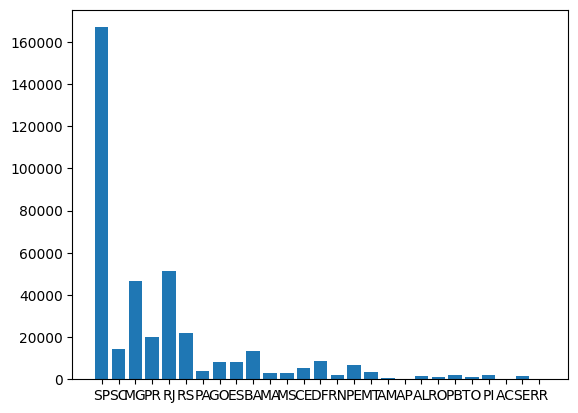

In [98]:
# Q.5) Count the number of customers from each state. 
query=""" SELECT customer_state ,COUNT( customer_id) from customers 
        GROUP BY customer_state   """ 
cursor.execute(query)     
data = cursor.fetchall()   

df=pd.DataFrame(data,columns=["state","customer_count"])
# df

#plot bar 
plt.bar(df["state"],df["customer_count"])
plt.show()

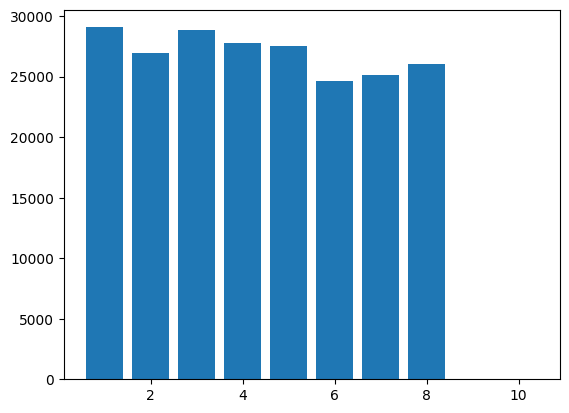

In [117]:
## Intermediate Queries

# 1. Calculate the number of orders per month in 2018.

query = """
    SELECT MONTH(order_purchase_timestamp) AS Month_Name, 
    COUNT(order_id) AS No_of_orders   FROM  orders
    WHERE    YEAR(order_purchase_timestamp) = 2018
    GROUP BY Month_Name  ORDER BY Month_Name ASC ;
"""

# Execute the query
cursor.execute(query)
data = cursor.fetchall()

df=pd.DataFrame(data,columns=["months","No_of_orders"])
# df

#plot bar 
plt.bar(df["months"],df["No_of_orders"])
plt.show()


In [ ]:
# 2. Find the average number of products per order, grouped by customer city.
query = """
   
"""

# Execute the query
cursor.execute(query)
data = cursor.fetchall()
data